# IPDxIRR_2F (Ionospheric plasma densities)

> Abstract: Access to the derived plasma characteristics at 1Hz (level 2 product).

In [3]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

viresclient: 0.11.3
pandas     : 1.4.1
xarray     : 2023.8.0
matplotlib : 3.5.1



In [1]:
from viresclient import SwarmRequest
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy
from matplotlib.dates import DateFormatter
from matplotlib.patches import Rectangle
request = SwarmRequest()

## IPDxIRR_2F product information

Derived plasma characteristics at 1Hz, for each Swarm spacecraft.

Documentation:
- https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-2-product-definitions#IPDxIRR_2F

### Check what "IPD" data variables are available

In [2]:
request.available_collections("IPD", details=False)

{'IPD': ['SW_OPER_IPDAIRR_2F', 'SW_OPER_IPDBIRR_2F', 'SW_OPER_IPDCIRR_2F']}

In [3]:
request.available_measurements("IPD")

['Ne',
 'Te',
 'Background_Ne',
 'Foreground_Ne',
 'PCP_flag',
 'Grad_Ne_at_100km',
 'Grad_Ne_at_50km',
 'Grad_Ne_at_20km',
 'Grad_Ne_at_PCP_edge',
 'ROD',
 'RODI10s',
 'RODI20s',
 'delta_Ne10s',
 'delta_Ne20s',
 'delta_Ne40s',
 'Num_GPS_satellites',
 'mVTEC',
 'mROT',
 'mROTI10s',
 'mROTI20s',
 'IBI_flag',
 'Ionosphere_region_flag',
 'IPIR_index',
 'Ne_quality_flag',
 'TEC_STD']

## Fetch three hours of IPD data

In [4]:
request.set_collection("SW_OPER_IPDAIRR_2F")
request.set_products(measurements=request.available_measurements("IPD"))
df1 = request.get_between(
    dt.datetime(2019,3,1, 20,54,10),
    dt.datetime(2019,3,1, 20,55,11)
)

request.set_collection("SW_OPER_IPDAIRR_2F")
request.set_products(measurements=request.available_measurements("IPD"))
df2 = request.get_between(
    dt.datetime(2019,3,25, 19,0,0),
    dt.datetime(2019,3,25, 19,1,2)
)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.262MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.262MB)

### Load and plot using pandas/matplotlib

In [5]:
df1 = df1.as_dataframe()

df2 = df2.as_dataframe()

In [6]:
needed_data1 = df1[['Longitude','Latitude','Background_Ne','Ne', 'Grad_Ne_at_20km',
                        'Te', 'ROD', 'delta_Ne10s', 'IPIR_index', 'Ionosphere_region_flag']]        # Blobs

needed_data2 = df2[['Longitude','Latitude','Background_Ne','Ne', 'Grad_Ne_at_20km',
                        'Te', 'ROD', 'delta_Ne10s', 'IPIR_index', 'Ionosphere_region_flag']]

### Electron Density Scaling

In [7]:
needed_data1_scaled = needed_data1.copy()
needed_data2_scaled = needed_data2.copy()

In [8]:
needed_data1_scaled['Ne'] = (needed_data1_scaled['Ne'] - needed_data1_scaled['Ne'].min())\
/ (needed_data1_scaled['Ne'].max() - needed_data1_scaled['Ne'].min())


needed_data2_scaled['Ne'] = (needed_data2_scaled['Ne'] - needed_data2_scaled['Ne'].min())\
/ (needed_data2_scaled['Ne'].max() - needed_data2_scaled['Ne'].min())

Ne Variance Without SSFiI: 0.1022054371513231
Ne Variance With SSFiI: 0.07374996252131806


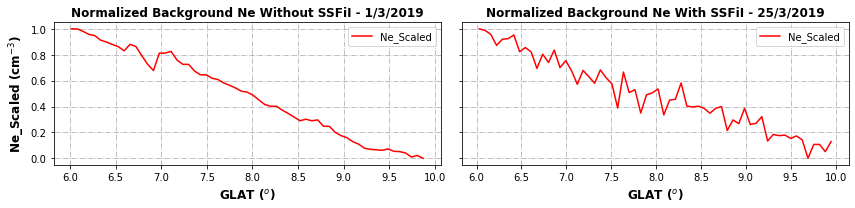

In [10]:
std_no_SSFiI = needed_data1_scaled['Ne'].var()
std_with_SSFiI = needed_data2_scaled['Ne'].var()

print(f"Ne Variance Without SSFiI: {std_no_SSFiI}\nNe Variance With SSFiI: {std_with_SSFiI}")

figure, ax = plt.subplots(1,2, sharey=True, figsize=(12,3))
ax[0].plot(needed_data1_scaled['Latitude'],
           needed_data1_scaled['Ne'],
           label='Ne_Scaled',
          color = 'red')
ax[0].set_title("Normalized Background Ne Without SSFiI - 1/3/2019",
               fontweight='bold')
ax[0].set_ylabel('Ne_Scaled (cm$^{-3}$)', fontsize=12, fontweight='bold')
ax[0].set_xlabel('GLAT ($^{o}$)', fontsize=12, fontweight='bold')

ax[1].plot(needed_data2_scaled['Latitude'],
           needed_data2_scaled['Ne'],
           label='Ne_Scaled',
          color = 'red')
ax[1].set_title("Normalized Background Ne With SSFiI - 25/3/2019",
               fontweight='bold')
ax[1].set_xlabel('GLAT ($^{o}$)', fontsize=12, fontweight='bold')

for axes in ax.flat:
    axes.grid(True, linestyle='-.')
    axes.legend()
figure.tight_layout()
plt.show()

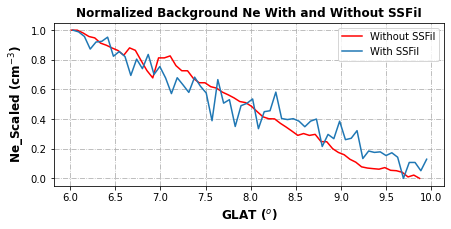

In [11]:
plt.figure(figsize=(7,3))
plt.plot(needed_data1_scaled['Latitude'],
           needed_data1_scaled['Ne'],
           label='Without SSFiI',
          color = 'red')
plt.plot(needed_data2_scaled['Latitude'],
           needed_data2_scaled['Ne'], label='With SSFiI')
plt.title("Normalized Background Ne With and Without SSFiI",
               fontweight='bold')
plt.ylabel('Ne_Scaled (cm$^{-3}$)', fontsize=12, fontweight='bold')
plt.xlabel('GLAT ($^{o}$)', fontsize=12, fontweight='bold')
plt.grid(True, linestyle = '-.')
plt.legend()
#plt.savefig("CAR_NASRDA/With_Without_SSFiI.tiff", bbox_inches='tight')
plt.show()

### Peak-to-Peak Method

In [12]:
from scipy import signal

# Read the CSV file
df = pd.read_csv('CAR_NASRDA/SSFiI_25_3_2019_A.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort the dataframe by timestamp
df.sort_values('Timestamp', inplace=True)

# Calculate latitudinal difference
df['lat_diff'] = df['Latitude'].diff()

# Identify peaks and troughs in electron density
electron_density = df['Ne']
peaks, _ = signal.find_peaks(electron_density)
troughs, _ = signal.find_peaks(-electron_density)

# Calculate latitudinal peak-to-peak differences
lat_diff_peaks = df.loc[peaks, 'Latitude'].diff()
lat_diff_troughs = df.loc[troughs, 'Latitude'].diff()

# Calculate time differences for peaks and troughs
time_diff_peaks = df.loc[peaks, 'Timestamp'].diff().dt.total_seconds()
time_diff_troughs = df.loc[troughs, 'Timestamp'].diff().dt.total_seconds()

# Calculate frequencies
frequency_peaks = 1 / time_diff_peaks
frequency_troughs = 1 / time_diff_troughs

# Create new columns in the dataframe
df['lat_diff_peaks'] = lat_diff_peaks
df['lat_diff_troughs'] = lat_diff_troughs
df['time_diff_peaks'] = time_diff_peaks
df['time_diff_troughs'] = time_diff_troughs
df['frequency_peaks'] = frequency_peaks
df['frequency_troughs'] = frequency_troughs

In [14]:
# Display the dataframe
df.head()

,Timestamp,Longitude,Latitude,Background_Ne,Ne,Grad_Ne_at_20km,Te,ROD,delta_Ne10s,IPIR_index,Ionosphere_region_flag,lat_diff,lat_diff_peaks,lat_diff_troughs,time_diff_peaks,time_diff_troughs,frequency_peaks,frequency_troughs
0,2019-03-25 19:00:00.196999936,6.123507,9.948902,300628.3125,298273.1,0.020560,2429.979029,0.0,296.80,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-03-25 19:00:01.197007872,6.122399,9.884660,300628.3125,296924.3,-0.030320,2435.418681,0.0,296.80,3,0,-0.064242,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-25 19:00:02.196999936,6.121289,9.820418,300628.3125,297894.1,-0.020243,2457.065020,0.0,92.05,3,0,-0.064242,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-25 19:00:03.196999936,6.120177,9.756176,300628.3125,297893.0,-0.000029,2461.232045,0.0,141.90,3,0,-0.064242,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-25 19:00:04.196999936,6.119065,9.691934,300628.3125,296027.1,0.026728,2473.390123,2.2,380.10,3,0,-0.064242,NaN,-0.192725,NaN,2.999992,NaN,0.333334


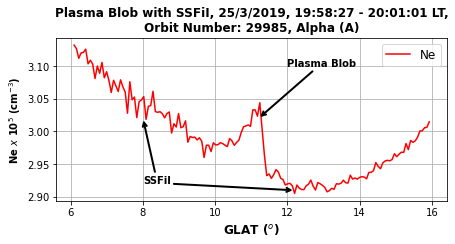

In [53]:
plt.figure(figsize=(7,3))
# plt.plot(needed_data1['Latitude'], needed_data1['Background_Ne']/100000,
#          'b--', label='Background_Ne')
plt.plot(needed_data1['Latitude'], needed_data1['Ne']/100000, color='red', label= 'Ne')
#plt.title('EPBs, Alpha (A) over Nigeria, February 15 2019, 21:23 hr (LT)',
          #fontweight='bold', fontsize=10)
plt.xlabel('GLAT ($^{o}$)', fontsize=12, fontweight='bold')
plt.ylabel('Ne $x$ 10$^{5}$ (cm$^{-3}$)', fontweight='bold')
# plt.title('15/8/2019, 19:01:30 - 19:04:59 hr (LT),\n Alpha(A), Orbit No: 32191, GLON: 8.10$^{o}$N',
#           fontweight='bold', fontsize=10)
plt.legend(loc='upper right', ncol=2, fontsize=12)
plt.grid()
plt.annotate("Plasma Blob", xy=(11.2, 3.02), xytext=(12, 3.10),
            arrowprops=dict(facecolor='black', linewidth = 2, arrowstyle="->"), fontweight='bold')
plt.annotate('SSFiI', xy=(8, 3.02), xytext=(8, 2.92),
            arrowprops=dict(facecolor='black', linewidth = 2, arrowstyle="->"), fontweight='bold')
plt.annotate('', xy=(12.2, 2.91), xytext=(8.8, 2.92),
            arrowprops=dict(facecolor='black', linewidth = 2, arrowstyle="->"), fontweight='bold')
plt.title('Plasma Blob with SSFiI, 25/3/2019, 19:58:27 - 20:01:01 LT,\nOrbit Number: 29985, Alpha (A)',
         fontweight='bold')
#plt.savefig("CAR_NASRDA/Blob_SSFiI_2532019.tiff", bbox_inches='tight')
plt.show()

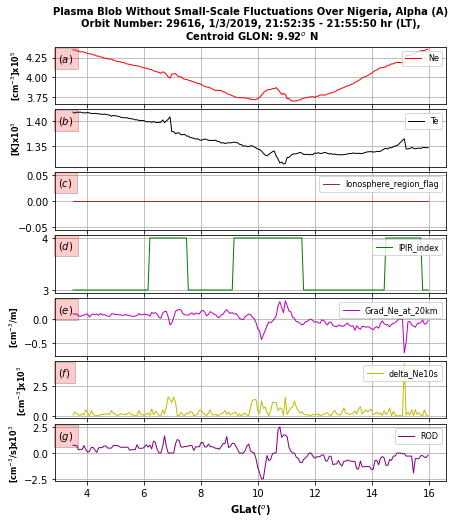

In [88]:
fi, axe = plt.subplots(7, sharex=True, figsize=(7,8))

axe[0].plot(needed_data1['Latitude'], needed_data1['Ne']/100000, '-', lw=1, label='Ne', color='red')
axe[0].set_title('Plasma Blob Without Small-Scale Fluctuations Over Nigeria, Alpha (A)\nOrbit Number: 29616, 1/3/2019, 21:52:35 - 21:55:50 hr (LT),\n Centroid GLON: 9.92$^{o}$ N',
                 fontsize=10, fontweight='bold')
axe[0].set_ylabel('[cm$^{-3}$]x10$^{5}$', fontsize=8, fontweight='bold')
axe[0].text(3.0, 4.20, "$(a)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))


axe[1].plot(needed_data1['Latitude'], needed_data1['Te']/1000, '-',
            markersize=3, lw=1, label='Te', color='black')
axe[1].set_ylabel('[K]x10$^{3}$', fontsize=8, fontweight='bold')
axe[1].text(3.0, 1.395, "$(b)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

axe[2].plot(needed_data1['Latitude'], needed_data1['Ionosphere_region_flag'], '-',
            markersize=3, lw=1, label='Ionosphere_region_flag', color='brown')
axe[2].text(3.0, 0.03, "$(c)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

axe[3].plot(needed_data1['Latitude'], needed_data1['IPIR_index'], '-',
            markersize=3, lw=1, label='IPIR_index', color='green')
axe[3].text(3.0, 3.8, "$(d)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

axe[4].plot(needed_data1['Latitude'], needed_data1['Grad_Ne_at_20km'], '-',
            markersize=3, lw=1, label='Grad_Ne_at_20km', color='m')
axe[4].set_ylabel('[cm$^{-3}$/m]', fontsize=8, fontweight='bold')
axe[4].text(3.0, 0.13, "$(e)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

axe[5].plot(needed_data1['Latitude'], needed_data1['delta_Ne10s']/1000, '-',
            markersize=3, lw=1, label='delta_Ne10s', color='y')
axe[5].set_ylabel('[cm$^{-3}$]x10$^{3}$', fontsize=8, fontweight='bold')
axe[5].text(3.0, 3.35, "$(f)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

axe[6].plot(needed_data1['Latitude'], needed_data1['ROD']/1000, '-',
            markersize=3, lw=1, label='ROD', color='purple')
axe[6].set_xlabel('GLat($^{o}$)', fontweight='bold')
axe[6].set_ylabel('[cm$^{-3}$/s]x10$^{3}$', fontsize=8, fontweight='bold')
axe[6].text(3.0, 1.3, "$(g)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))
               
for ax in axe.flat:
    #ax.set(xlabel='GLat($^{o}$)', ylabel='Ne x 10$^{5}$(cm$^{-3}$)')
    #ax.label_outer()
    ax.grid()
    ax.legend(loc='upper right', ncol=2, fontsize=8)
fi.subplots_adjust(hspace=0.1)
#plt.savefig('CAR_NASRDA/blob_no_SSFiI_132019.tiff', format='tiff', bbox_inches='tight')
plt.show()

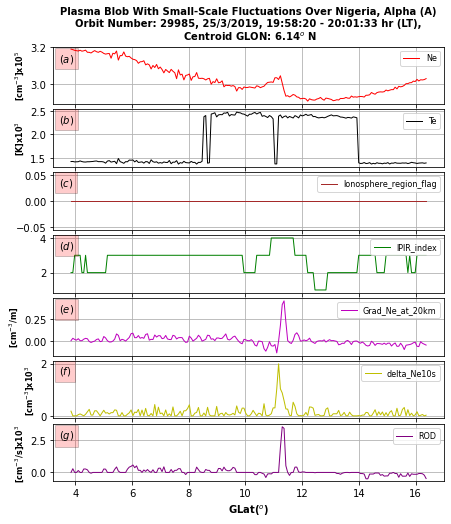

In [82]:
fi, axe = plt.subplots(7, sharex=True, figsize=(7,8))

axe[0].plot(needed_data1['Latitude'], needed_data1['Ne']/100000, '-', lw=1, label='Ne', color='red')
axe[0].set_title('Plasma Blob With Small-Scale Fluctuations Over Nigeria, Alpha (A)\nOrbit Number: 29985, 25/3/2019, 19:58:20 - 20:01:33 hr (LT),\n Centroid GLON: 6.14$^{o}$ N',
                 fontsize=10, fontweight='bold')
axe[0].set_ylabel('[cm$^{-3}$]x10$^{5}$', fontsize=8, fontweight='bold')
axe[0].text(3.42, 3.12, "$(a)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

#----------------------------------------------------------------------------------
axe[1].plot(needed_data1['Latitude'], needed_data1['Te']/1000, '-',
            markersize=3, lw=1, label='Te', color='black')
axe[1].set_ylabel('[K]x10$^{3}$', fontsize=8, fontweight='bold')
axe[1].text(3.42, 2.25, "$(b)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

# ----------------------------------------------------------------------------------
axe[2].plot(needed_data1['Latitude'], needed_data1['Ionosphere_region_flag'], '-',
            markersize=3, lw=1, label='Ionosphere_region_flag', color='brown')
axe[2].text(3.42, 0.03, "$(c)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

# ----------------------------------------------------------------------------------
axe[3].plot(needed_data1['Latitude'], needed_data1['IPIR_index'], '-',
            markersize=3, lw=1, label='IPIR_index', color='green')
axe[3].text(3.42, 3.4, "$(d)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

# -----------------------------------------------------------------------------------
axe[4].plot(needed_data1['Latitude'], needed_data1['Grad_Ne_at_20km'], '-',
            markersize=3, lw=1, label='Grad_Ne_at_20km', color='m')
axe[4].set_ylabel('[cm$^{-3}$/m]', fontsize=8, fontweight='bold')
axe[4].text(3.42, 0.33, "$(e)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

# ----------------------------------------------------------------------------------------
axe[5].plot(needed_data1['Latitude'], needed_data1['delta_Ne10s']/1000, '-',
            markersize=3, lw=1, label='delta_Ne10s', color='y')
axe[5].set_ylabel('[cm$^{-3}$]x10$^{3}$', fontsize=8, fontweight='bold')
axe[5].text(3.42, 1.6, "$(f)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

# ----------------------------------------------------------------------------------------
axe[6].plot(needed_data1['Latitude'], needed_data1['ROD']/1000, '-',
            markersize=3, lw=1, label='ROD', color='purple')
axe[6].set_xlabel('GLat($^{o}$)', fontweight='bold')
axe[6].set_ylabel('[cm$^{-3}$/s]x10$^{3}$', fontsize=8, fontweight='bold')
axe[6].text(3.42, 2.6, "$(g)$", fontweight='bold', bbox=dict(facecolor='red', alpha=0.2))

# ----------------------------------------------------------------------------------------
for ax in axe.flat:
    #ax.set(xlabel='GLat($^{o}$)', ylabel='Ne x 10$^{5}$(cm$^{-3}$)')
    #ax.label_outer()
    ax.grid()
    ax.legend(loc='upper right', ncol=2, fontsize=8)
fi.subplots_adjust(hspace=0.1)
#plt.savefig('CAR_NASRDA/blob_with_SSFiI_2532019.tiff', format='tiff', bbox_inches='tight')
plt.show()

### Blobs Associated With SSFiI: Uniform Characteristics

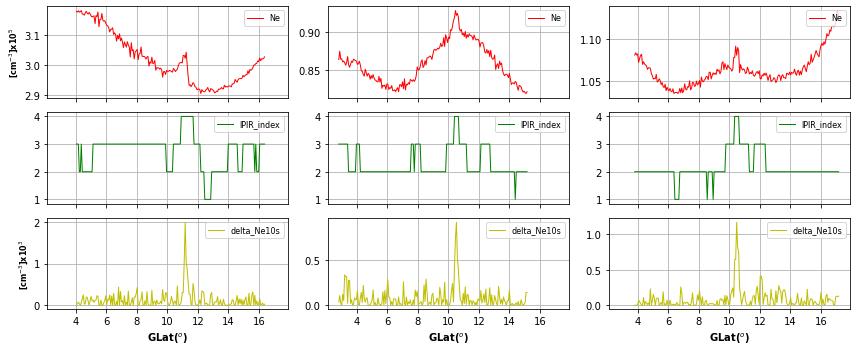

In [40]:
fi, axe = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(12,5))

axe[0,0].plot(needed_data1['Latitude'], needed_data1['Ne']/100000, '-', lw=1, label='Ne', color='red')
axe[0,0].set_ylabel('[cm$^{-3}$]x10$^{5}$', fontsize=8, fontweight='bold')

# --------------------------------------------------------------------------------------------------------
axe[1,0].plot(needed_data1['Latitude'], needed_data1['IPIR_index'], '-',
            markersize=3, lw=1, label='IPIR_index', color='green')

# --------------------------------------------------------------------------------------------------------
axe[2,0].plot(needed_data1['Latitude'], needed_data1['delta_Ne10s']/1000, '-',
            markersize=3, lw=1, label='delta_Ne10s', color='y')
axe[2,0].set_ylabel('[cm$^{-3}$]x10$^{3}$', fontsize=8, fontweight='bold')
axe[2,0].set_xlabel('GLat($^{o}$)', fontweight='bold')

# --------------------------------------------------------------------------------------------------------
axe[0,1].plot(needed_data2['Latitude'], needed_data2['Ne']/100000, '-', lw=1, label='Ne', color='red')

# --------------------------------------------------------------------------------------------------------
axe[1,1].plot(needed_data2['Latitude'], needed_data2['IPIR_index'], '-',
            markersize=3, lw=1, label='IPIR_index', color='green')

# --------------------------------------------------------------------------------------------------------
axe[2,1].plot(needed_data2['Latitude'], needed_data2['delta_Ne10s']/1000, '-',
            markersize=3, lw=1, label='delta_Ne10s', color='y')
axe[2,1].set_xlabel('GLat($^{o}$)', fontweight='bold')

# --------------------------------------------------------------------------------------------------------
axe[0,2].plot(needed_data3['Latitude'], needed_data3['Ne']/100000, '-', lw=1, label='Ne', color='red')

# --------------------------------------------------------------------------------------------------------
axe[1,2].plot(needed_data3['Latitude'], needed_data3['IPIR_index'], '-',
            markersize=3, lw=1, label='IPIR_index', color='green')

# --------------------------------------------------------------------------------------------------------
axe[2,2].plot(needed_data3['Latitude'], needed_data3['delta_Ne10s']/1000, '-',
            markersize=3, lw=1, label='delta_Ne10s', color='y')
axe[2,2].set_xlabel('GLat($^{o}$)', fontweight='bold')

# --------------------------------------------------------------------------------------------------------               
for ax in axe.flat:    
    ax.grid()
    ax.legend(loc='upper right', ncol=2, fontsize=8)
fi.subplots_adjust(hspace=0.1)
plt.tight_layout()
#plt.savefig('CAR_NASRDA/SSFiI_blob_IPIR_signature.tiff', format='tiff', bbox_inches='tight')
plt.show()

### Spectral Analysis of SSFiI

In [15]:
request.set_collection("SW_OPER_IPDAIRR_2F")
request.set_products(measurements=request.available_measurements("IPD"))
data = request.get_between(
    dt.datetime(2019,3,25, 18,59,54),
    dt.datetime(2019,3,25, 19,1,44)
)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.262MB)

In [16]:
df = data.as_dataframe()
df.head()

,IBI_flag,Grad_Ne_at_100km,Grad_Ne_at_PCP_edge,Ne_quality_flag,ROD,mROTI10s,Te,mROTI20s,Spacecraft,delta_Ne40s,...,Latitude,Num_GPS_satellites,Ionosphere_region_flag,mVTEC,PCP_flag,RODI20s,Longitude,mROT,Ne,TEC_STD
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-03-25 18:59:54.196999936,0,-0.015291,0.0,10000,-170.0,0.002033,2465.155918,0.001961,A,753.45,...,10.334358,6,0,11.181376,0,97.450619,6.130134,0.001463,297686.9,1.534280
2019-03-25 18:59:55.196999936,0,-0.009722,0.0,10000,0.0,0.001886,2450.040811,0.001964,A,902.60,...,10.270115,6,0,11.185193,0,106.265340,6.129033,-0.000097,297903.9,1.534939
2019-03-25 18:59:56.196999936,0,-0.006943,0.0,10000,0.0,0.001634,2426.556777,0.001927,A,794.55,...,10.205872,6,0,11.189449,0,139.457475,6.127930,0.000402,298150.3,1.535777
2019-03-25 18:59:57.197007872,0,-0.005704,0.0,10000,0.0,0.001695,2428.474381,0.001919,A,1002.70,...,10.141629,6,0,11.194118,0,163.101960,6.126826,0.002653,298280.6,1.537484
2019-03-25 18:59:58.196999936,0,-0.004056,0.0,10000,0.0,0.002059,2388.281566,0.001933,A,1127.70,...,10.077387,6,0,11.195981,0,165.735051,6.125721,0.001493,297976.3,1.534952


In [17]:
df.columns

Index(['IBI_flag', 'Grad_Ne_at_100km', 'Grad_Ne_at_PCP_edge',
       'Ne_quality_flag', 'ROD', 'mROTI10s', 'Te', 'mROTI20s', 'Spacecraft',
       'delta_Ne40s', 'Foreground_Ne', 'delta_Ne10s', 'delta_Ne20s',
       'IPIR_index', 'Grad_Ne_at_50km', 'RODI10s', 'Background_Ne',
       'Grad_Ne_at_20km', 'Radius', 'Latitude', 'Num_GPS_satellites',
       'Ionosphere_region_flag', 'mVTEC', 'PCP_flag', 'RODI20s', 'Longitude',
       'mROT', 'Ne', 'TEC_STD'],
      dtype='object')

In [18]:
df = df[['IPIR_index', 'Latitude', 'delta_Ne10s', 'Longitude', 'Te', 'Ne']]

In [19]:
df_Ne = df[['Ne', 'delta_Ne10s']]
df_Ne.head()

,Ne,delta_Ne10s
Timestamp,,
2019-03-25 18:59:54.196999936,297686.9,108.55
2019-03-25 18:59:55.196999936,297903.9,211.00
2019-03-25 18:59:56.196999936,298150.3,78.70
2019-03-25 18:59:57.197007872,298280.6,0.00
2019-03-25 18:59:58.196999936,297976.3,0.00


In [20]:
from scipy.fftpack import fft
import numpy as np

In [21]:
# Sample electron density data
ne_values = df_Ne['Ne'].values

In [22]:
# Perform FFT
ne_fft = fft(ne_values)
N = len(ne_fft)
n = np.arange(N)
sampling_rate = 1
T = N / sampling_rate
frequency = n / T

In [23]:
# Extract one-sided frequency range
n_oneside = N // 2
frequency_oneside = frequency[:n_oneside]

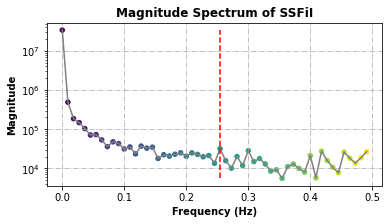

In [24]:
# Plot the magnitude spectrum
plt.figure(figsize=(6, 3))
plt.plot(frequency_oneside, np.abs(ne_fft[:n_oneside]), 'gray')
plt.scatter(frequency_oneside, np.abs(ne_fft[:n_oneside]), s=20, c=frequency_oneside)
plt.yscale('log')
plt.title('Magnitude Spectrum of SSFiI', fontweight='bold')
plt.xlabel('Frequency (Hz)', fontweight='bold')
plt.ylabel('Magnitude', fontweight='bold')
plt.grid(True, linestyle='-.')
plt.vlines(x=0.255, ymin=np.min(np.abs(ne_fft[:n_oneside])),
           ymax=np.max(np.abs(ne_fft[:n_oneside])), linestyle='--', color='red')
#plt.savefig('CAR_NASRDA/SSFiI_magnitude_spectrum.tiff', bbox_inches='tight')
plt.show()

/tmp/ipykernel_84/857733060.py:2: RuntimeWarning: divide by zero encountered in true_divide
  time_hours = 1 / frequency_oneside / (60 * 60)


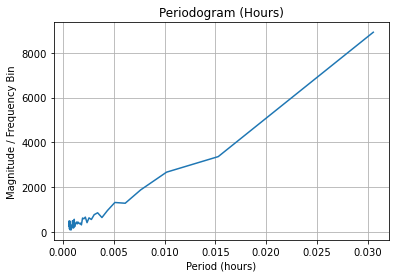

In [25]:
# Calculate and plot periodogram in hours
time_hours = 1 / frequency_oneside / (60 * 60)
plt.plot(time_hours, np.abs(ne_fft[:n_oneside]) / n_oneside)
plt.title('Periodogram (Hours)')
plt.xlabel('Period (hours)')
plt.ylabel('Magnitude / Frequency Bin')
# plt.xlim(0, 0.04)
# plt.ylim(0, 200000)
plt.grid()
plt.show()

/tmp/ipykernel_84/452864360.py:2: RuntimeWarning: divide by zero encountered in true_divide
  time_seconds = 1 / frequency_oneside


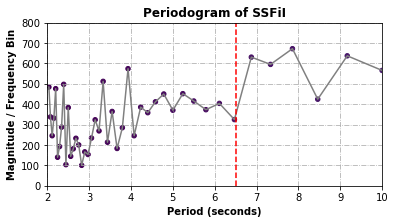

In [26]:
# Calculate and plot periodogram in seconds
time_seconds = 1 / frequency_oneside
magnitude_frequency_normalized = np.abs(ne_fft[:n_oneside]) / n_oneside
plt.figure(figsize=(6,3))
plt.plot(time_seconds, magnitude_frequency_normalized, 'gray')
plt.scatter(time_seconds, magnitude_frequency_normalized, s=20, c=time_seconds)
plt.title('Periodogram of SSFiI', fontweight='bold')
plt.xlabel('Period (seconds)', fontweight='bold')
plt.ylabel('Magnitude / Frequency Bin', fontweight='bold')
plt.xlim(2, 10)
plt.ylim(0, 800)
plt.grid(True, linestyle='-.')
plt.vlines(x=6.5, ymin=0, ymax=800, linestyle='--', color='red')
#plt.savefig('CAR_NASRDA/SSFiI_Periodogram.tiff', bbox_inches='tight')
plt.show()

/tmp/ipykernel_84/3379325255.py:13: RuntimeWarning: divide by zero encountered in true_divide
  time_seconds = 1 / frequency_oneside


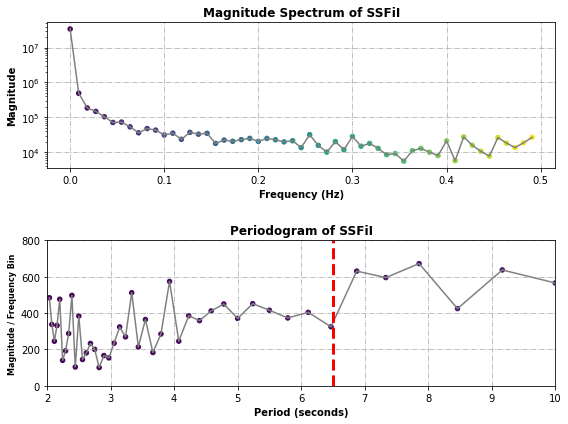

In [27]:
# Plot the magnitude spectrum
fig, ax = plt.subplots(2, figsize=(8,6))
#plt.figure(figsize=(6, 3))
ax[0].plot(frequency_oneside, np.abs(ne_fft[:n_oneside]), 'gray')
ax[0].scatter(frequency_oneside, np.abs(ne_fft[:n_oneside]), s=20, c=frequency_oneside)
ax[0].set_yscale('log')
ax[0].set_title('Magnitude Spectrum of SSFiI', fontweight='bold')
ax[0].set_xlabel('Frequency (Hz)', fontweight='bold')
ax[0].set_ylabel('Magnitude', fontweight='bold')
ax[0].grid(True, linestyle='-.')

# Calculate and plot periodogram in seconds
time_seconds = 1 / frequency_oneside
magnitude_frequency_normalized = np.abs(ne_fft[:n_oneside]) / n_oneside
ax[1].plot(time_seconds, magnitude_frequency_normalized, 'gray')
ax[1].scatter(time_seconds, magnitude_frequency_normalized, s=20, c=time_seconds)
ax[1].set_title('Periodogram of SSFiI', fontweight='bold')
ax[1].set_xlabel('Period (seconds)', fontweight='bold')
ax[1].set_ylabel('Magnitude / Frequency Bin', fontweight='bold', fontsize=8)
ax[1].set_xlim(2, 10)
ax[1].set_ylim(0, 800)
ax[1].grid(True, linestyle='-.')
ax[1].vlines(x=6.5, ymin=0, ymax=800, linestyle='--', lw=3, color='red')
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)
#plt.savefig('CAR_NASRDA/SSFiI_Magnitude_Periodogram.tiff', bbox_inches='tight')
plt.show()

### Occurrence Patterns of Blobs

In [29]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 3.3 MB/s eta 0:00:0000:01


In [33]:
df = pd.read_excel('CAR_NASRDA/Blob_Avg_Data.xlsx')

In [34]:
df.head()

,Months,No_of_Obs,No_of_Cases,Avg_Centroid_Density,Avg_Blob_N_S_Ssize,Avg_GLAT,Avg_GLON,Occurrence rate (%)
0,January,3,1,98703.60,132.100,10.45,15.350,33.333333
1,February,15,2,250083.00,77.700,10.38,15.130,13.333333
2,March,17,4,343179.45,129.315,10.82,10.185,23.529412
3,April,1,0,0.00,0.000,0.00,0.000,0.000000
4,May,2,0,0.00,0.000,0.00,0.000,0.000000


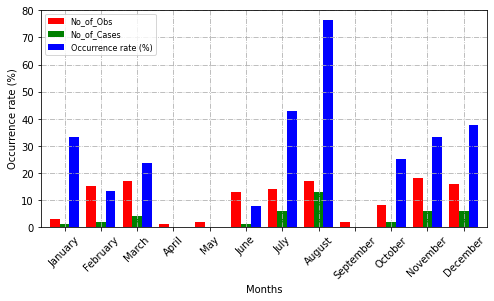

In [36]:
def bar_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'left')

df.plot(kind='bar', x='Months', y=['No_of_Obs', 'No_of_Cases', 'Occurrence rate (%)'],
        color=['red', 'green','blue'], figsize=(8,4), width=0.8)
#plt.ylim((0,25))
plt.xticks(rotation=45)
plt.ylabel('Occurrence rate (%)')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True, linestyle='-.')
#plt.savefig(r'.../NASRDA\Results/obs_by_cases.tiff', bbox_inches='tight')
plt.show()